In [2]:
import os
if os.path.isdir('/scratch/dmpowell'):
    os.environ['TRANSFORMERS_CACHE'] = '/scratch/dmpowell/.cache/huggingface'
print(os.getenv('TRANSFORMERS_CACHE'))

import numpy as np

import pandas as pd
import json
import janitor

from easyeditor.custom import * # gets my custom functions

from ast import literal_eval

/scratch/dmpowell/.cache/huggingface


/home/dmpowell/.conda/envs/EasyEdit/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/dmpowell/.conda/envs/EasyEdit/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
def load_result(filename):
    x = pd.read_csv(filename, converters={'fwd_choices':literal_eval, 'rev_choices':literal_eval})
    return(x)


## overview

One edit type

1. Category-membership: Editing the category to which an exemplar belongs (e.g. "a Labrador is kind of a cow")

3 test types

1. Edit confirmation
2. Generalization: to properties of the exemplar assigned to a new category (those properties implied by its assignment)
3. localization: testing whether shared properties remain accurate (e.g. a Labrador is a cow --> a labrador has {four legs})

2 query types (forward and reverse)


## Table 1

In [22]:
def result_table(res, method_name):
    # compute overall score
    out = (
        pd.concat([
    (
        res
        .loc[lambda x: x.edit_type == "category membership"]
        .loc[lambda x: x.property != "category_membership"]
        .agg(overall_performance_fwd = ("correct_fwd", "mean"))
    ),

    (
        res
        .loc[lambda x: x.edit_type == "category membership"]
        .loc[lambda x: x.property == "category_membership"]
        .agg(efficacy = ("correct_fwd", "mean"))
        
    ),

    (
        res
        .loc[lambda x: x.edit_type == "category membership"]
        .loc[lambda x: ~x.property.str.startswith("category_membership")]
        .loc[lambda x: x.answer_changed == 0]
        .agg(locality = ("correct_fwd", "mean"))
    ),
    (
        res
        .loc[lambda x: x.edit_type == "category membership"]
        .loc[lambda x: ~x.property.str.startswith("category_membership")]
        .loc[lambda x: x.answer_changed == 1]
        # .groupby(["token_type"])
        .agg(generalization = ("correct_fwd", "mean"))
    ),

    (
        res
        .loc[lambda x: x.edit_type == "category membership"]
        .loc[lambda x: ~x.property.str.startswith("category_membership")]
        .loc[lambda x: x.answer_changed == 1]
        .groupby(["token_type"])
        .agg(correct_fwd = ("correct_fwd", "mean"))
    )
    ]).assign(
        measure = ["Score", "efficacy", "specificity", "generalization","generalization", "generalization"],
        group = ["overall", "overall", "overall", "overall", "atypical", "typical"]
    ).filter(["measure", "group", "correct_fwd"]).rename(columns = {"correct_fwd": method_name })
    )

    return(out)


res_ft = load_result("results/csv/meta-llama-Llama-2-7b-hf-FTcatmem-full.csv")
res_ice = load_result("results/csv/meta-llama-Llama-2-7b-hf-ICEcatmem-full.csv")
res_rome = load_result("results/csv/meta-llama-Llama-2-7b-hf-ROMEcatmem-sampletest-mom2.csv")
# res_memit = load_result("results/csv/meta-llama-Llama-2-7b-hf-MEMITcatmem-sampletest-mom2.csv")
res_base = load_result("results/csv/meta-llama-Llama-2-7b-hf-BASEcatmem-full.csv")

table1  = result_table(res_ft, "FT").merge(result_table(res_rome, "ROME")).merge(result_table(res_ice, "IKE")).merge(result_table(res_base, "BASE"))

table1

# Table 1: Forward-query performance for FT, ROME, and IKE editing methods. Score represents overall generalization performance 
# for exemplar properties following categorical editing. Efficacy indicates performance


,measure,group,FT,ROME,IKE,BASE
0,Score,overall,0.314594,0.469697,0.545635,0.244489
1,efficacy,overall,0.980533,0.780000,0.995902,0.032787
2,specificity,overall,0.733696,0.742857,0.913043,0.775815
3,generalization,overall,0.233421,0.411043,0.474474,0.141579
4,generalization,atypical,0.248947,0.373737,0.480526,0.149474
5,generalization,typical,0.217895,0.468750,0.468421,0.133684


Table 1: Multiple-choice forward-query performance for FT, ROME, and IKE editing methods. Score represents overall generalization performance for exemplar properties following categorical editing. Efficacy indicates performance for queries of the edited relation. Locality represents performance for unchanged properties following edities. Generalization indicates performance for queries testing properties of exemplars that should be expected to change following the new category assignment.

## Figure 1

results figure

In [31]:
def make_plot_result(res, method_name):

    out = (
        res
        # .loc[lambda x: x.edit_type == "category membership"]
        .loc[lambda x: ~x.property.str.startswith("category_membership")]
        .loc[lambda x: x.answer_changed == 1]
        .assign(
            chance_fwd = lambda d: d.apply(lambda x: 1/len(x.fwd_choices), 1),
            chance_rev = lambda d: d.apply(lambda x: 1/len(x.rev_choices), 1) 
        )
        .filter(['entity', 'token_type', 'edit', 'correct_fwd', 'correct_rev'])
        .pivot_longer(
                index = [ 'entity','token_type','edit'],
                names_to = ('var', 'query_type'),
                names_sep = '_'
        )
        .groupby(["query_type", "var"])
        .agg(estimate = ("value", "mean"), n = ("value", "count"))
        .assign(method = method_name)
        .assign(
            ul = lambda x: x.estimate + np.sqrt(x.estimate * (1 - x.estimate) / x.n),
            ll = lambda x: x.estimate - np.sqrt(x.estimate * (1 - x.estimate) / x.n)
            )
        .reset_index()
    )

    return(out)

fig_df = pd.concat(
    [
        
        make_plot_result(res_base, "Unedited"),
        make_plot_result(res_ft, "FT"),
        make_plot_result(res_rome, "ROME"),
        make_plot_result(res_ice, "IKE")
    ]
    
)

fig_df

,query_type,var,estimate,n,method,ul,ll
0,fwd,correct,0.141579,3800,Unedited,0.147234,0.135924
1,rev,correct,0.102105,3800,Unedited,0.107017,0.097193
0,fwd,correct,0.233421,3800,FT,0.240283,0.226559
1,rev,correct,0.040789,3800,FT,0.043998,0.037581
0,fwd,correct,0.411043,163,ROME,0.449581,0.372505
1,rev,correct,0.061350,163,ROME,0.080146,0.042554
0,fwd,correct,0.474474,3800,IKE,0.482574,0.466373
1,rev,correct,0.998421,3800,IKE,0.999065,0.997777


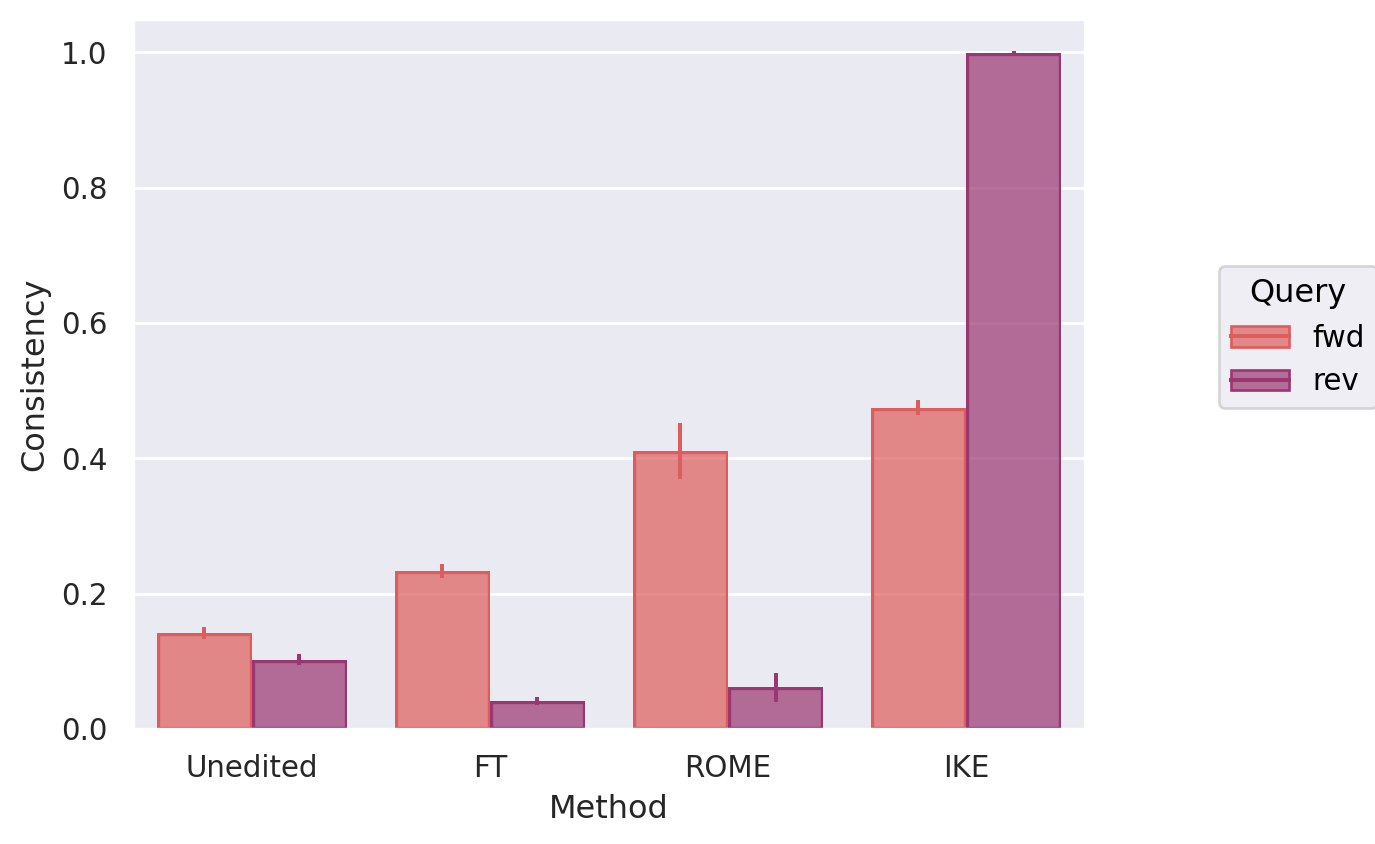

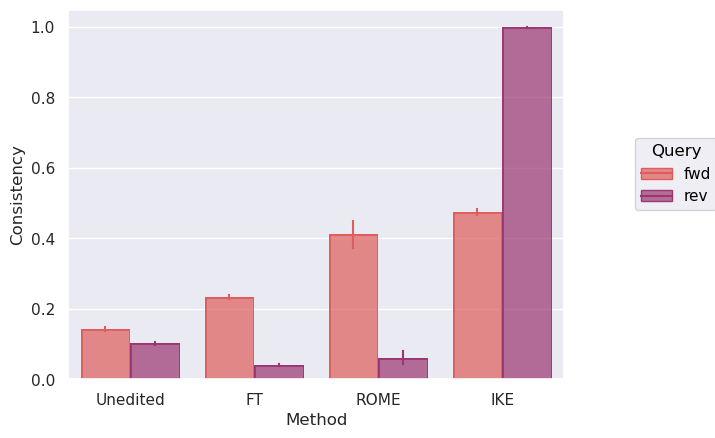

In [32]:
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
ax = plt.figure()

fig = (
    so.Plot(fig_df, x = "method", y = "estimate", color = "query_type")
    # .facet("query_type")
    .add(so.Bar(), so.Agg(), so.Dodge())
    .add(so.Range(), so.Dodge(), ymax = "ul", ymin = "ll")
    .label(x = "Method", y = "Consistency", color = "Query")
    .scale(color = "flare")
    # .add(so.Lines(), so.Agg(), y = "chance")
    .on(ax)
    .plot()
)

fig
# ax.axhline(y = .25, linestyle = "--", color = "grey")

# ax.show()

## Key Findings

- Edit Success
    - FT and ROME both successfully edit category memberships in forward queries (94%)
    - FT and ROME both fail completely to edit for reverse queries (as expected)
- Locality
    - ???
- Generalization
    - Category membership edits by ROME do *somewhat* generalize across category properties (greater than chance)
    - Edits generalize better for uncommon or atypical exemplars -- consistent with idea that it is easier to edit less popular knowledge (can cite that paper).
    - IKE offers the best generalization performance
    - (near) Ceiling performance for IKE on all reversed-queries is likely just an artifact of having the token string in the prompt--probably affects RippleEdit findings substantially as well.

## Conclusions

- We introduce a challenging benchmark for editing generalization quality
- ROME produces *some* generalization, giving some hope for localization and editing methods that modify LLM representations
- May offer hints to implicit structure of representations inside LLMs


In [33]:
def make_plot_result2(res, method_name):

    out = (
        res
        .loc[lambda x: x.edit_type == "category membership"]
        .loc[lambda x: ~x.property.str.startswith("category_membership")]
        .loc[lambda x: x.answer_changed == 1]
        .assign(
            chance_fwd = lambda d: d.apply(lambda x: 1/len(x.fwd_choices), 1),
            chance_rev = lambda d: d.apply(lambda x: 1/len(x.rev_choices), 1) 
        )
        .filter(['entity', 'superordinate_category', 'token_type', 'edit', 'correct_fwd', 'correct_rev'])
        .pivot_longer(
                index = ['superordinate_category', 'entity','token_type','edit'],
                names_to = ('var', 'query_type'),
                names_sep = '_'
        )
        .groupby(['superordinate_category', "query_type", "var"])
        .agg(estimate = ("value", "mean"), n = ("value", "count"))
        .assign(method = method_name)
        .assign(
            ul = lambda x: x.estimate + np.sqrt(x.estimate * (1 - x.estimate) / x.n),
            ll = lambda x: x.estimate - np.sqrt(x.estimate * (1 - x.estimate) / x.n)
            )
        .reset_index()
    )

    return(out)

fig_df2 = pd.concat(
    [
        make_plot_result2(res_ft, "FT"),
        make_plot_result2(res_rome, "ROME"),
        make_plot_result2(res_ice, "IKE"),
        make_plot_result2(res_base, "Unedited")
    ]
    
)

fig_df2.loc[lambda x: x.query_type == "fwd"]

,superordinate_category,query_type,var,estimate,n,method,ul,ll
0,animal,fwd,correct,0.225877,1368,FT,0.237183,0.214571
2,drink,fwd,correct,0.327083,480,FT,0.348497,0.305670
4,food,fwd,correct,0.244898,392,FT,0.266618,0.223178
6,instrument,fwd,correct,0.163110,656,FT,0.177535,0.148685
8,plant,fwd,correct,0.220000,400,FT,0.240712,0.199288
10,vehicle,fwd,correct,0.257937,504,FT,0.277424,0.238449
0,animal,fwd,correct,0.333333,36,ROME,0.411901,0.254766
2,drink,fwd,correct,0.361111,36,ROME,0.441165,0.281057
4,food,fwd,correct,0.428571,21,ROME,0.536561,0.320582
6,instrument,fwd,correct,0.555556,27,ROME,0.651185,0.459926


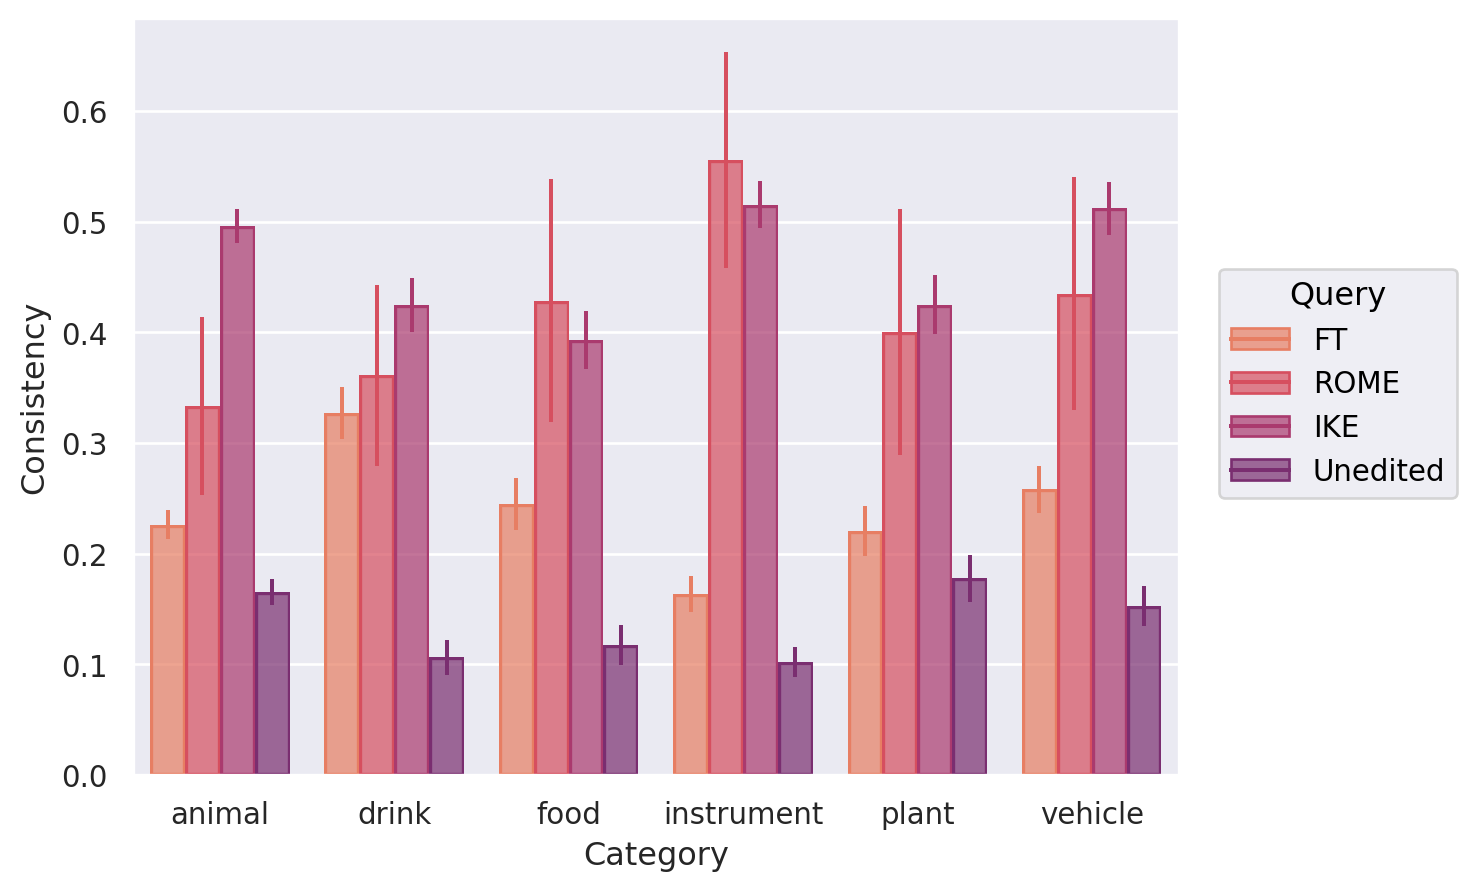

In [34]:
 (
    so.Plot(fig_df2.loc[lambda x: x.query_type == "fwd"], x = "superordinate_category", y = "estimate", color = "method")
    # .facet("query_type")
    .add(so.Bar(), so.Agg(), so.Dodge())
    .add(so.Range(), so.Dodge(), ymax = "ul", ymin = "ll")
    .label(x = "Category", y = "Consistency", color = "Query")
    .scale(color = "flare")
    # .add(so.Lines(), so.Agg(), y = "chance")
    # .on(ax)
    .plot()
)

# Old stuff


----

In [ ]:
res_ice.loc[lambda x: x.edit_type == "category membership"].loc[lambda x: x.property == "category_membership"].shape#.loc[lambda x: ~x.property.str.startswith("category_membership")].shape

In [6]:
res_ice = load_result("results/csv/meta-llama-Llama-2-7b-hf-ICE.csv")
print(len(res_ice))
report_results(res_ice)

998


/home/dmpowell/.conda/envs/EasyEdit/lib/python3.9/site-packages/janitor/functions/pivot.py:903: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  values = {values_to: concat_compat(values)}


prop  \
var                                                                     chance   
answer_changed test_group                      query_type token_type             
0.0            CM: token property              fwd        rare        0.300595   
                                                          typical     0.281609   
                                               rev        rare        0.250000   
                                                          typical     0.250000   
1.0            CM: category membership (exact) fwd        rare        0.145062   
                                                          typical     0.150085   
                                               rev        rare        0.093384   
                                                          typical     0.097458   
               CM: token property              fwd        rare        0.266667   
                                                          typical     0.263034   
                                               rev        rare        0.250000   
                                                          typical     0.250000   

                                                                                \
var                                                                    correct   
answer_changed test_group                      query_type token_type             
0.0            CM: token property              fwd        rare        0.857143   
                                                          typical     0.931034   
                                               rev        rare        1.000000   
                                                          typical     1.000000   
1.0            CM: category membership (exact) fwd        rare        1.000000   
                                                          typical     1.000000   
                                               rev        rare        1.000000   
                                                          typical     1.000000   
               CM: token property              fwd        rare        0.574468   
                                                          typical     0.474359   
                                               rev        rare        1.000000   
                                                          typical     1.000000   

                                                                          n  \
var                                                                  chance   
answer_changed test_group                      query_type token_type          
0.0            CM: token property              fwd        rare         28.0   
                                                          typical      29.0   
                                               rev        rare         28.0   
                                                          typical      29.0   
1.0            CM: category membership (exact) fwd        rare        108.0   
                                                          typical     112.0   
                                               rev        rare        108.0   
                                                          typical     112.0   
               CM: token property              fwd        rare         94.0   
                                                          typical      78.0   
                                               rev        rare         94.0   
                                                          typical      78.0   

                                                                              
var                                                                  correct  
answer_changed test_group                      query_type token_type          
0.0            CM: token property              fwd        rare          28.0  
                                                          typical       29.0  
                               

In [5]:
res_rome = load_result("results/csv/meta-llama-Llama-2-7b-hf-ROME.csv")
print(len(res_rome))
report_results(res_rome)

998


/home/dmpowell/.conda/envs/EasyEdit/lib/python3.9/site-packages/janitor/functions/pivot.py:903: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  values = {values_to: concat_compat(values)}


prop  \
var                                                                     chance   
answer_changed test_group                      query_type token_type             
0.0            CM: token property              fwd        rare        0.300595   
                                                          typical     0.281609   
                                               rev        rare        0.250000   
                                                          typical     0.250000   
1.0            CM: category membership (exact) fwd        rare        0.145062   
                                                          typical     0.150085   
                                               rev        rare        0.093384   
                                                          typical     0.097458   
               CM: token property              fwd        rare        0.266667   
                                                          typical     0.263034   
                                               rev        rare        0.250000   
                                                          typical     0.250000   

                                                                                \
var                                                                    correct   
answer_changed test_group                      query_type token_type             
0.0            CM: token property              fwd        rare        0.785714   
                                                          typical     0.655172   
                                               rev        rare        0.535714   
                                                          typical     0.344828   
1.0            CM: category membership (exact) fwd        rare        0.851852   
                                                          typical     0.821429   
                                               rev        rare        0.111111   
                                                          typical     0.071429   
               CM: token property              fwd        rare        0.500000   
                                                          typical     0.512821   
                                               rev        rare        0.404255   
                                                          typical     0.217949   

                                                                          n  \
var                                                                  chance   
answer_changed test_group                      query_type token_type          
0.0            CM: token property              fwd        rare         28.0   
                                                          typical      29.0   
                                               rev        rare         28.0   
                                                          typical      29.0   
1.0            CM: category membership (exact) fwd        rare        108.0   
                                                          typical     112.0   
                                               rev        rare        108.0   
                                                          typical     112.0   
               CM: token property              fwd        rare         94.0   
                                                          typical      78.0   
                                               rev        rare         94.0   
                                                          typical      78.0   

                                                                              
var                                                                  correct  
answer_changed test_group                      query_type token_type          
0.0            CM: token property              fwd        rare          28.0  
                                                          typical       29.0  
                               